In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
plt.rcParams["figure.figsize"] = [16, 12]

In [2]:
class Net:
    def __init__(self, counts):
        self.input = tf.placeholder(tf.float32, [None, counts[0]], name="input")
        flow = self.input
        for c in counts[1:]:
            flow = tf.layers.dense(flow, c, activation="relu")
        self.output = tf.layers.dense(flow, 1, activation="tanh")

def do_optimization(sess, title, loss, opt, training_steps, feed_dict):
    loss_plot = []
    for _ in xrange(training_steps):
        l, _ = sess.run(
            [loss, opt],
            feed_dict=feed_dict,
        )
        loss_plot.append(l)
    print "Final loss:", l
    plt.clf()
    plt.title(title)
    plt.plot(loss_plot)
    plt.savefig(title + ".png", dpi=600)

In [3]:
INPUT_SIZE         = 10
ARCHITECTURE_REAL  = [INPUT_SIZE] + [10, 10, 10]
ARCHITECTURE_PROXY = [INPUT_SIZE] + [10, 10, 10]
TRAINING_SAMPLES   = 200
TRAINING_STEPS     = 2000
LEARNING_RATE      = 0.1

In [4]:
# Create all required networks.
real_utility  = Net(ARCHITECTURE_REAL)
proxy_utility = Net(ARCHITECTURE_PROXY)
learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

total_parameters = int(sum(np.product(var.shape) for var in tf.trainable_variables()))
random_count = int(0.5 * total_parameters)
random_xs = np.random.randn(random_count, INPUT_SIZE)
random_ys = np.tanh(np.random.randn(random_count, 1))

Final loss: 0.11302067


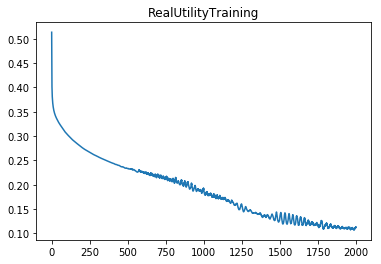

In [5]:
# Do a first pass of training real_utility on our random data.
desired_output = tf.placeholder(tf.float32, [None, 1], name="desired_output")
loss = tf.reduce_mean(
    tf.squared_difference(real_utility.output, desired_output),
)
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

do_optimization(
    sess,
    "RealUtilityTraining",
    loss,
    opt,
    TRAINING_STEPS,
    {
        real_utility.input: random_xs,
        desired_output: random_ys,
        learning_rate: LEARNING_RATE,
    },
)

Final loss: 0.03137453


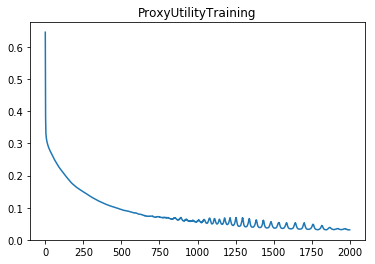

In [6]:
# Now train proxy_utility to match real_utility.
training_set = np.random.randn(TRAINING_SAMPLES, INPUT_SIZE)

loss = tf.reduce_mean(
    tf.squared_difference(
        tf.stop_gradient(real_utility.output),
        proxy_utility.output,
    ),
)
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

do_optimization(
    sess,
    "ProxyUtilityTraining",
    loss,
    opt,
    TRAINING_STEPS,
    {
        real_utility.input: training_set,
        proxy_utility.input: training_set,
        learning_rate: LEARNING_RATE,
    },
)

## Rejection sampling

In [7]:
grad_opt = tf.train.GradientDescentOptimizer(learning_rate=-1.0)
(input_gradient, _), = grad_opt.compute_gradients(proxy_utility.output, var_list=[proxy_utility.input])

In [8]:
sample = np.random.randn(INPUT_SIZE)

In [9]:
actual_gradient = sess.run(
    input_gradient,
    feed_dict={
        proxy_utility.input: [sample],
    },
)

In [10]:
finite_differences = []
step_size = 0.001
for axis in xrange(INPUT_SIZE):
    u1, u2 = sess.run(
        proxy_utility.output,
        feed_dict={
            proxy_utility.input: [
                sample,
                np.squeeze(sample + step_size * np.eye(INPUT_SIZE)[axis]),
            ],
        }
    )
    finite_differences.append(u2 - u1)
finite_differences = np.array(finite_differences)

In [11]:
def compute_utility(n, samples):
    return sess.run(
        n.output,
        feed_dict={
            n.input: samples,
        },
    )

def optimize_samples(samples, step_size, steps):
    samples = np.array(samples).copy()
    for _ in xrange(steps):
        step_directions = sess.run(
            input_gradient,
            feed_dict={
                proxy_utility.input: samples,
            },
        )
        samples += step_directions * step_size
    return samples

## Scatter plots

Compute a scatter plot of proxy utility vs real utility on purely random inputs.

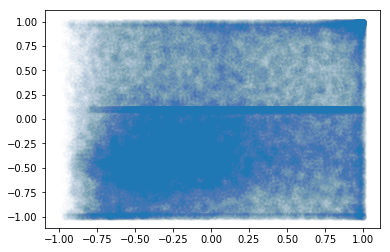

In [12]:
N = 1000000
SCATTER_COUNT = 100000
samples = np.random.randn(N, INPUT_SIZE)
random_xs = compute_utility(proxy_utility, samples)
random_ys = compute_utility(real_utility, samples)
plt.scatter(random_xs[:SCATTER_COUNT], random_ys[:SCATTER_COUNT], alpha=0.01)

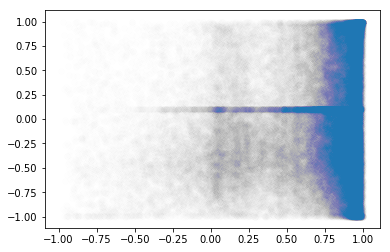

In [13]:
optimized_samples = optimize_samples(samples, 0.1, 10)
optimized_xs = compute_utility(proxy_utility, optimized_samples)
optimized_ys = compute_utility(real_utility, optimized_samples)
plt.scatter(optimized_xs[:SCATTER_COUNT], optimized_ys[:SCATTER_COUNT], alpha=0.005)

In [14]:
def smooth(xs, ys, epsilon, x):
    return np.mean(ys[np.abs(xs - x) < epsilon])

def bucket_count(xs, epsilon, x):
    return np.sum(abs(xs - x) < epsilon)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  


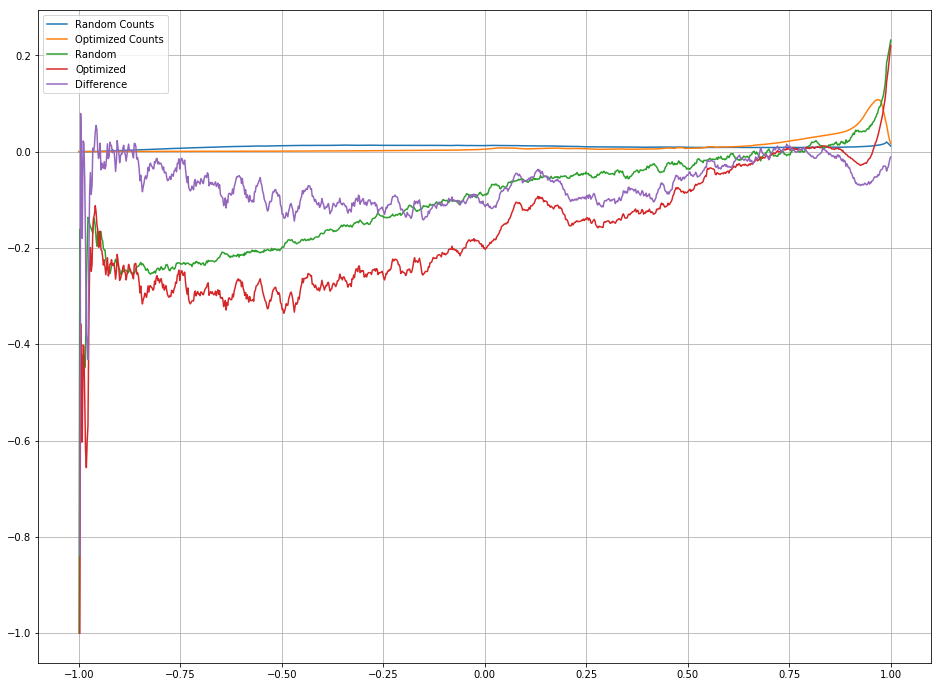

In [18]:
smoothed_xs = np.linspace(-1, 1, 1000)
plt.hold(True)
EPSILON = 0.01

random_y = map(lambda x: smooth(random_xs, random_ys, EPSILON, x), smoothed_xs)
optimized_y = map(lambda x: smooth(optimized_xs, optimized_ys, EPSILON, x), smoothed_xs)

plt.plot(
    smoothed_xs,
    1e-6 * np.array(map(lambda x: bucket_count(random_xs, EPSILON, x), smoothed_xs)),
)
plt.plot(
    smoothed_xs,
    1e-6 * np.array(map(lambda x: bucket_count(optimized_xs, EPSILON, x), smoothed_xs)),
)
plt.plot(
    smoothed_xs,
    random_y,
)
plt.plot(
    smoothed_xs,
    optimized_y,
)
plt.plot(
    smoothed_xs,
    np.array(optimized_y) - random_y
)
plt.grid()
plt.legend(["Random Counts", "Optimized Counts", "Random", "Optimized", "Difference"])